In [1]:
import re       #for matching regular expression.
import cv2      #Python bindings designed to solve computer vision problems
import random    #generate random number.
from glob import glob       #return all file paths that match a specific pattern.github

from pprint import pprint
import warnings
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display_html

plt.rcParams.update({'font.size': 16})

# .dcm handling
import pydicom
import nibabel as nib
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Environment check
warnings.filterwarnings('ignore')

In [2]:
# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'


my_colors = [
    '#5EAFD9',
    '#449DD1',
    '#3977BB',
    '#2D51A5',
    '#5C4C8F',
    '#8B4679',
    '#C53D4C',
    '#E23836',
    '#FF4633',
    '#FF5746',
]
CMAP1 = ListedColormap(my_colors)


****

**show_values_on_bars:**
This function is used to plot the values at the end of a seaborn bar plot. It takes in the axs parameter, which represents the axis of the plot, h_v parameter to determine whether the bar plot is vertical or horizontal, and space parameter to control the spacing between the bars.


**_show_on_single_plot**
Inside the function, there is a nested function _show_on_single_plot that handles the actual plotting of the values on a single plot. The function iterates over the patches (bars) in the plot and adds the corresponding value as text using the ax.text method.

**natural_keys**
natural_keys function splits a string into digit and non-digit groups for human-friendly sorting.

In [3]:
def show_values_on_bars(axs, h_v='v', space=0.4):
    """Plots the value at the end of the seaborn bar plot.
    axs: the ax of the plot
    h_v: weather or not the bar plot is vertical/ horizontal"""

    def _show_on_single_plot(ax):
        if h_v == 'v':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha='center')
        elif h_v == 'h':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha='left')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    """
    alist.sort(key=natural_keys) sorts in human order
    https://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    """
    return [atoi(c) for c in re.split(r'(\d+)', text)]

In [4]:
BASE = '../input/rsna-2022-cervical-spine-fracture-detection'

In [5]:
def read_data():
    """Reads in all .csv files."""

    train = pd.read_csv(
        '../input/rsna-2022-cervical-spine-fracture-detection/train.csv'
    )
    train_bbox = pd.read_csv(
        '../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv'
    )
    test = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/test.csv')
    ss = pd.read_csv(
        '../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv'
    )

    return train, train_bbox, test, ss

In [6]:
def get_csv_info(csv, name='Default'):
    """Prints main information for the specified .csv file."""

    print(f'{clr.S}=== {name} ==={clr.E}')
    print(f'{clr.S}Shape:{clr.E}', csv.shape)
    print(
        f'{clr.S}Missing Values:{clr.E}',
        csv.isna().sum().sum(),
        'total missing datapoints.',
    )
    print(f'{clr.S}Columns:{clr.E}', list(csv.columns), '\n')

    display_html(csv.head())
    print('\n')

In [7]:
# Read in the data
train, train_bbox, test, ss = read_data()

# Print useful information on it
for csv, name in zip(
        [train, train_bbox, test, ss], ['Train', 'Train Bbox', 'Test', 'Sample Submission']
):
    get_csv_info(csv, name)

=== Train ===
Shape: (2019, 9)
Missing Values: 0 total missing datapoints.
Columns: ['StudyInstanceUID', 'patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] 



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0




=== Train Bbox ===
Shape: (7217, 6)
Missing Values: 0 total missing datapoints.
Columns: ['StudyInstanceUID', 'x', 'y', 'width', 'height', 'slice_number'] 



,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137




=== Test ===
Shape: (3, 3)
Missing Values: 0 total missing datapoints.
Columns: ['row_id', 'StudyInstanceUID', 'prediction_type'] 



,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1




=== Sample Submission ===
Shape: (3, 2)
Missing Values: 0 total missing datapoints.
Columns: ['row_id', 'fractured'] 



,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


**In this section we prints unique values of different parts of the 'StudyInstanceUID' column by splitting the values using dot as the separator.**

In [8]:
for i in range(7):
    print(train['StudyInstanceUID'].map(lambda x: x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


 # <u> Fracture Analysis and Number of Bones Fractured Per Patient.</u>

> # <u>Fracture Analysis</u>

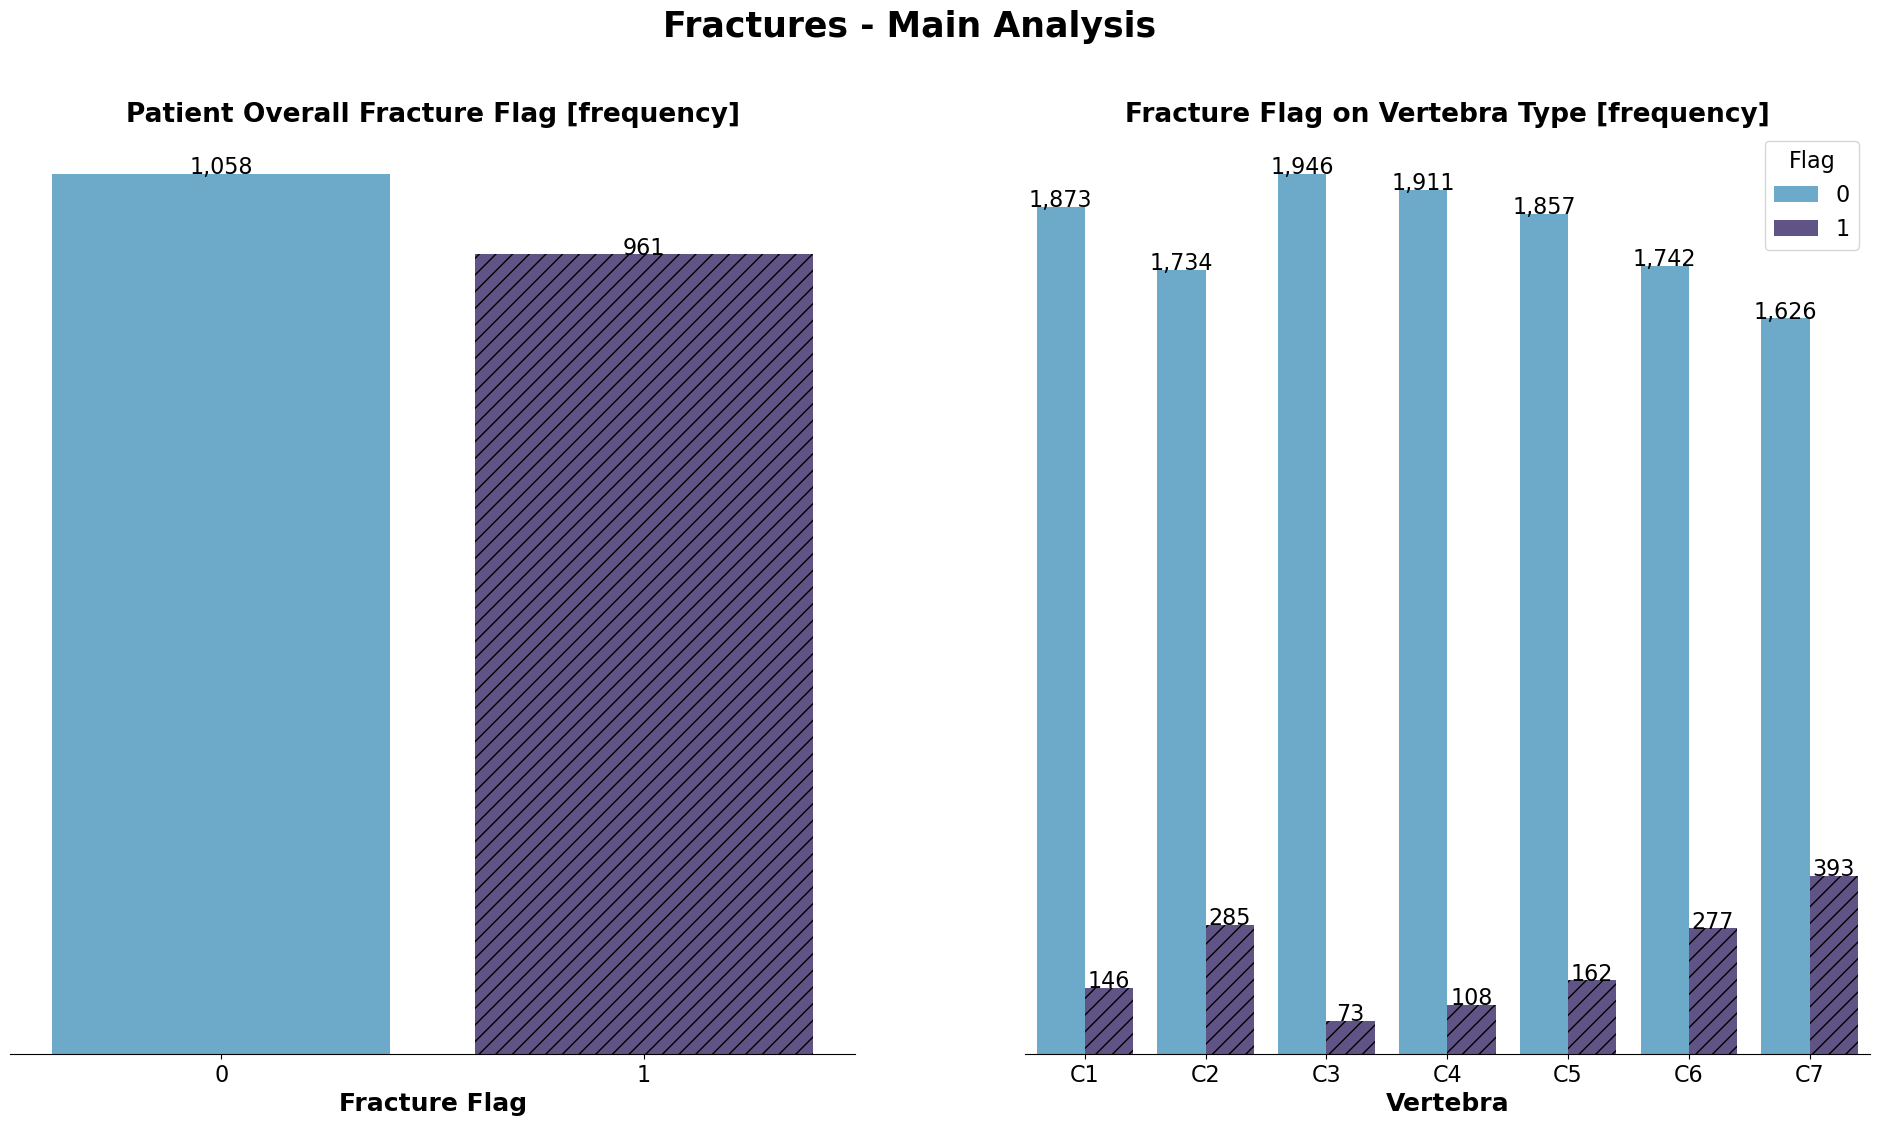

In [9]:
dt = pd.melt(
    train,
    id_vars=['StudyInstanceUID', 'patient_overall'],
    var_name='Vertebra',
    value_name='Flag',
)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Fractures - Main Analysis', weight='bold', size=25)

sns.countplot(
    data=train, x='patient_overall', ax=ax1, palette=[my_colors[0], my_colors[4]]
)
show_values_on_bars(ax1, h_v='v', space=0.4)
ax1.set_title('Patient Overall Fracture Flag [frequency]', weight='bold', size=19)
ax1.set_xlabel('Fracture Flag', size=18, weight='bold')
ax1.set_ylabel('')
ax1.set_yticks([])

hatches = itertools.cycle(['', '//'])
for bar in ax1.patches:
    hatch = next(hatches)
    bar.set_hatch(hatch)

sns.countplot(
    data=dt, x='Vertebra', hue='Flag', ax=ax2, palette=[my_colors[0], my_colors[4]]
)
show_values_on_bars(ax2, h_v='v', space=0.4)
ax2.set_title('Fracture Flag on Vertebra Type [frequency]', weight='bold', size=19)
ax2.set_xlabel('Vertebra', size=18, weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

for i, bar in enumerate(ax2.patches):
    hatch = ''
    if i in [7, 8, 9, 10, 11, 12, 13]:
        hatch = '//'
    bar.set_hatch(hatch)

sns.despine(right=True, top=True, left=True)

> **Classes are balanced - there is a 50/50 percent ratio between patients with and without fractures.**

> **• C7 - the bone that is most likely to be fractured.**<br> 
> **• C3 - the bone that is least likely to be fractured.**

> # <u>Number of Bones Fractured Per Patient</u>

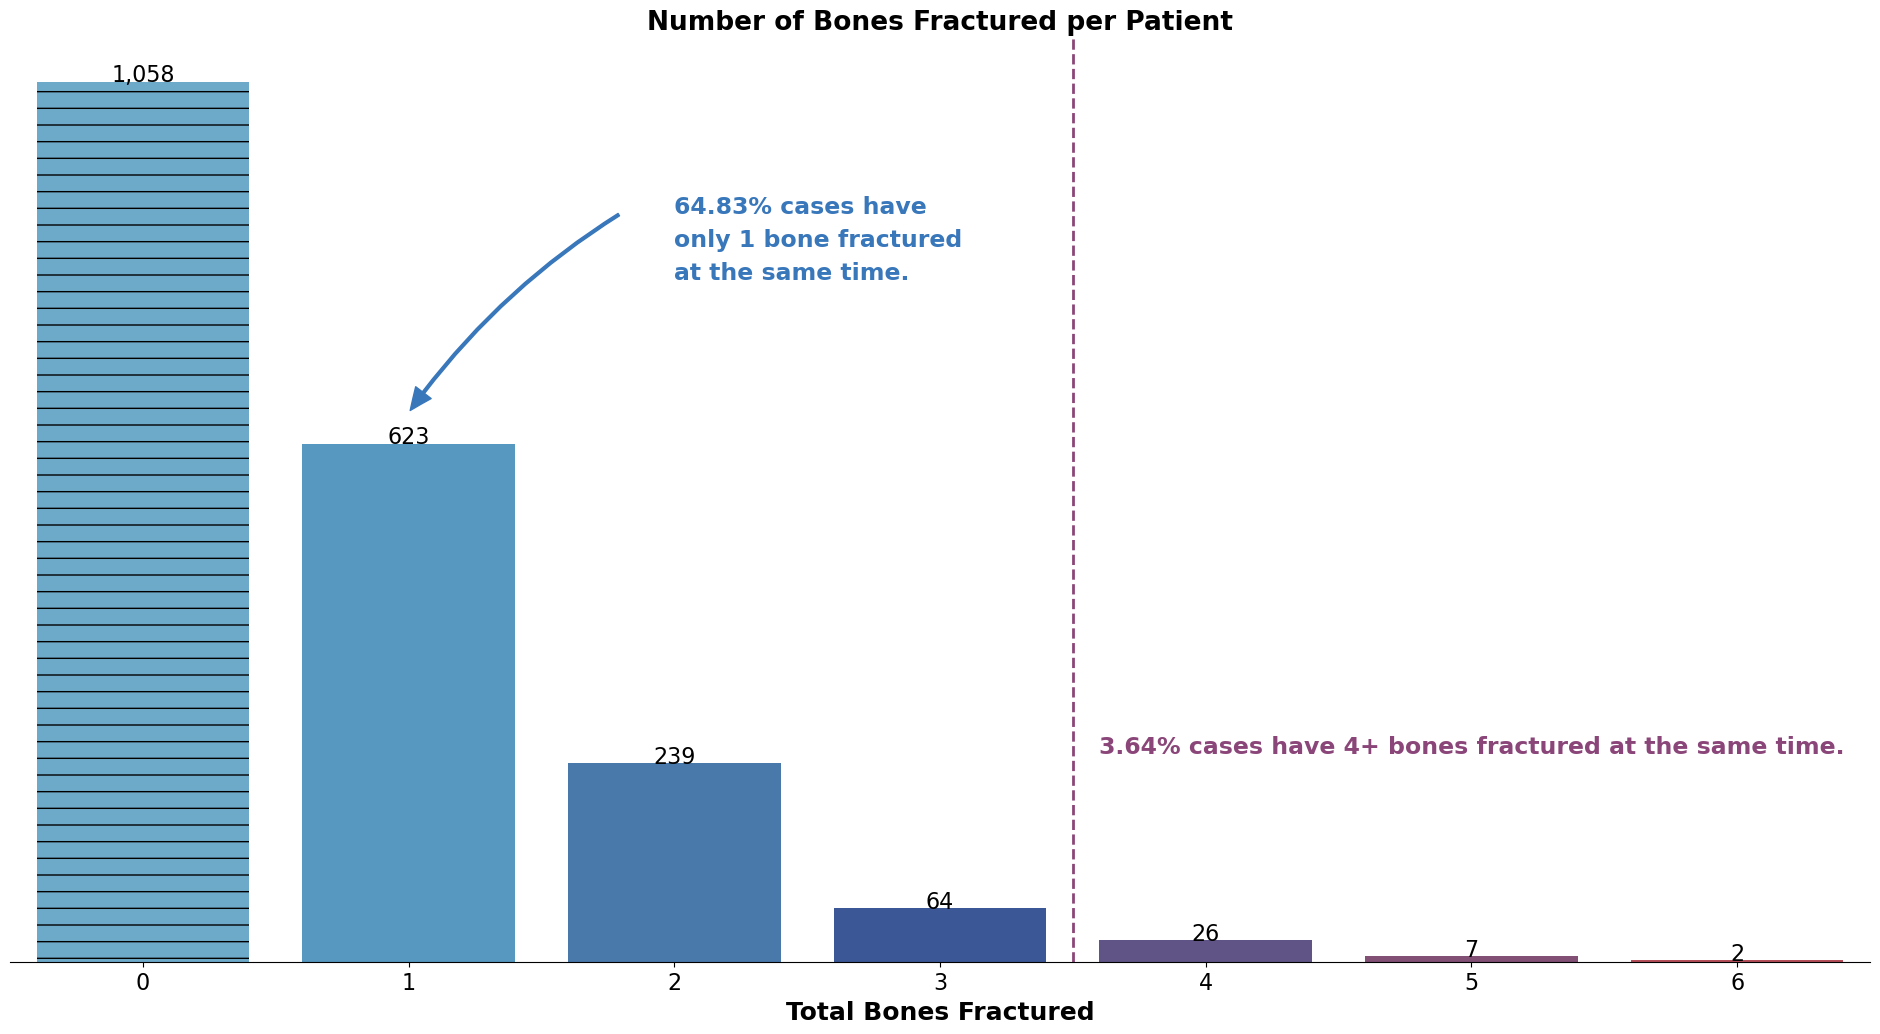

In [10]:
train['total_fractures'] = train.iloc[:, 2:].sum(axis=1)

# Plot
plt.figure(figsize=(24, 12))
axs = sns.countplot(data=train, x='total_fractures', palette=my_colors)
show_values_on_bars(axs, h_v='v', space=0.4)
plt.title('Number of Bones Fractured per Patient', weight='bold', size=19)
plt.xlabel('Total Bones Fractured', size=18, weight='bold')
plt.ylabel('')
plt.yticks([])

# Hatch
for i, bar in enumerate(axs.patches):
    hatch = ''
    if i == 0:
        hatch = '-'
    bar.set_hatch(hatch)

# Arrow
style = 'Simple, tail_width=2, head_width=14, head_length=16'
kw = dict(arrowstyle=style, color=my_colors[2])
arrow = patches.FancyArrowPatch(
    (1.8, 900), (1, 660), connectionstyle='arc3,rad=.10', **kw
)
plt.gca().add_patch(arrow)
plt.text(
    x=2,
    y=900,
    s=f'{round(623 / 961 * 100, 2)}% cases have',
    color=my_colors[2],
    size=17,
    weight='bold',
)
plt.text(
    x=2, y=860, s='only 1 bone fractured', color=my_colors[2], size=17, weight='bold'
)

plt.text(x=2, y=820, s='at the same time.', color=my_colors[2], size=17, weight='bold')

# Line
plt.axvline(x=3.5, linestyle='--', color=my_colors[5], lw=2)
plt.text(
    x=3.6,
    y=250,
    s=f'{round(35 / 961 * 100, 2)}% cases have 4+ bones fractured at the same time.',
    color=my_colors[5],
    size=17,
    weight='bold',
)

sns.despine(right=True, top=True, left=True)

> **• Single-bone injuries - of the 961 cases with at least one
fracture, more than half have a single-bone injury.**

> **• Multiple bone injuries - relatively rare occurrences in-
volve damage to four or more bones at the same time.**